# Double Descent with Random Fourier Features

In this section, we will demonstrate the double descent phenomenon when performing regression with Random Fourier Features (RFF).  Given a dataset $\{(x^{(i)}, y^{(i)})\}_{i=1}^{n} \subset \mathbb{R}^{d} \times \mathbb{R}$, we wish to learn a map from $x^{(i)} \to y^{(i)}$.  In order to learn this map, we will first transform the features $x^{(i)}$ via the following **feature map**: 

\begin{align*}
    \phi_k(x) = \frac{1}{\sqrt{k}} \begin{bmatrix} e^{i \langle v^{(1)}, x \rangle}\\
                                                 e^{i \langle v^{(1)}, x \rangle} \\
                                                 \vdots \\
                                                 e^{i \langle v^{(k)}, x \rangle}
                                                 \end{bmatrix}~~;
\end{align*}
where $v^{(j)} \sim \mathcal{N}(\mathbf{0}, I_{d \times d})$ for $j = 1, 2, \ldots, k$.  It is important to note that $\phi_k(x) \in \mathbb{C}^{k}$ and that the inner product in this space is given by: 
\begin{align*}
    \langle u, v \rangle = \sum_{i=1}^{k} u_k \bar{v}_k
\end{align*}
where $\bar{v}_k$ is the complex conjugate of $v_k$.  Given the map $\phi_k: \mathbb{R}^{d} \to \mathbb{C}^{k}$, we now use linear regression to map from $\phi_k(x^{(i)}) \to y^{(i)}$.  In particular, we use gradient descent to minimize the following loss: 
\begin{align}
    \mathcal{L}(w) = \sum_{i=1}^{n} ( y^{(i)} - w^T \phi_k(x^{(i)}))^2  ~~;
\end{align}
under the assumption that the parameters at initialization, $w^{(0)}$, are $0$. 

### Connection to Neural Networks

From the form of the loss function above, we see that the RFF model above is equivalent to a neural network with 1 hidden layer with $k$ hidden units and an elementwise activation function, $\psi: \mathbb{R} \to \mathbb{C}$, with $\psi(\xi) = \frac{1}{\sqrt{k}} e^{i \xi}$.


## Double Descent with Increasing Width
We next show that increasing $k$ (e.g. the width of the 1 hidden layer network above) empirically leads to double descent.  

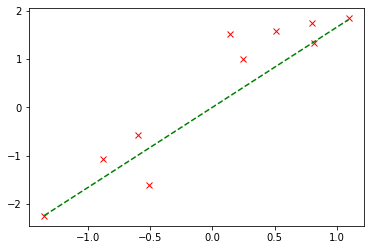

In [1]:
import dataloader as dl
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

SEED = 2134

np.random.seed(SEED)
# Dataset for regression
X, y, X_test, y_test, w = dl.make_dataset(n=10, d=1, eps=.5)

# Visualize Dataset (red) and True Solution (green)
plt.plot(X[0], y[0], 'rx')
plt.plot(X_test[0], y_test[0], 'g--')
plt.show()


### Code for RFF Regression with Finite Number of Features

1 1.9013119603246775 1.2049208764513415
5 0.17278681076158883 472.9248745370769
10 1.3858351510153538e-07 2.8522195042831014e+21
50 0 3217438971143.833
100 0 8467710151.176084
500 0 62558628.159007974
1000 0 15646312.643174944
5000 0 227626.01407115083
10000 0 37038.53470926179
100000 0 2056.558210257892


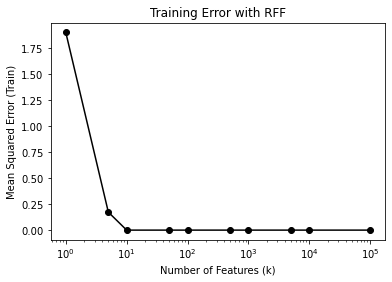

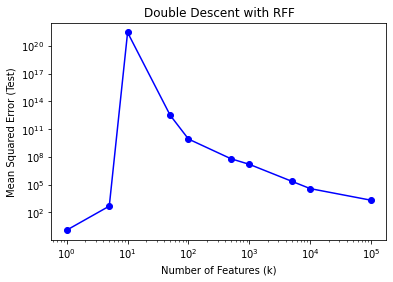

In [2]:
from numpy.linalg import pinv
SEED = 2134
np.random.seed(SEED)

def mse(preds, labels): 
    return np.mean(np.abs(np.power(preds - labels, 2)))
    

def RFF(X, k=100):
    d, n = X.shape
    V = np.random.randn(k, d)
    rff = 1/np.sqrt(k) * np.exp(1j * V @ X)
    return rff


# Vary the number of RFF used for regression
num_features = [1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 100000]
train_errors = []
test_errors = []

for num_feat in num_features: 
    # Compute RFF for train & test data
    phi_X = RFF(X, k=num_feat)
    phi_X_test = RFF(X_test, k=num_feat)
            
    # Solve linear regression on RFF
    w_hat = y @ pinv(phi_X)
    preds = w_hat @ phi_X_test

    # Compute MSE for test samples
    test_error = mse(preds, y_test)
    test_errors.append(test_error)
    
    train_error = mse(w_hat @ phi_X, y)
    if np.isclose(train_error, 0): 
        train_error = 0
    train_errors.append(train_error)
    print(num_feat, train_error, test_error)

    
plt.plot(num_features, train_errors, 'ko-')
plt.title("Training Error with RFF")
plt.xscale("log")
plt.xlabel("Number of Features (k)")
plt.ylabel("Mean Squared Error (Train)")
plt.show()

plt.plot(num_features, test_errors, 'bo-')
plt.title("Double Descent with RFF")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of Features (k)")
plt.ylabel("Mean Squared Error (Test)")
plt.show()    

We make the following observations from the above figure: 

1. The test error peaks when using 10 features (e.g. the number of features = the number of training samples).  This is not coincidental, we can actually prove that the error goes to infinity even for over-parameterized linear regression. 

2. The test error decreases when using greater than 10 features.  

Observation 2 above begs the questions: What happens as we increase the number of features to infinity? We now analyze this case in the following section.

## RFF with Infinitely Many Features

We will now show that using infinitely many RFF above (i.e. $k \to \infty$) is equivalent to solving kernel regression with the Gaussian kernel (aka the Radial Basis Function kernel).  To find the corresponding kernel when using infinitely many features, we compute the following inner product as $k \to \infty$: 
\begin{align*}
    \langle \phi_k(x), ~\phi(x') \rangle_{\mathcal{C}^{k}} &= \frac{1}{k} \sum_{j=1}^{k} e^{i \langle v^{(j)}, ~x \rangle} e^{-i \langle v^{(j)}, ~x' \rangle} ~~ \text{(Don't forget the negative from the conjugate.)} \\
    &= \frac{1}{k} \sum_{j=1}^{k} e^{i \langle v^{(j)} , ~ (x - x') \rangle }
\end{align*}

As $k \to \infty$, we apply the law of large numbers to conclude that: 
\begin{align*}
    \langle \phi_k(x), ~\phi(x') \rangle_{\mathcal{C}^{k}} &\to \mathbb{E}_{v \sim \mathcal{N}(\mathbf{0}, I_{d \times d})} \left[e^{i \langle v , ~ (x - x') \rangle } \right] \\
    &= \prod_{\ell=1}^{d} \frac{1}{\sqrt{2\pi}} \int_{\mathbb{R}} e^{i v_{\ell} (x_{\ell} - x'_{\ell})} e^{-\frac{v_{\ell}^2}{2}} dv \\
    &= \prod_{\ell=1}^{d} e^{- (x_{\ell} - x'_{\ell})^2} \\
    &= e^{- \| x - x'\|_2^2}
\end{align*}

Now that we have a closed form for the inner product $\langle \phi_k(x), ~\phi(x') \rangle_{\mathcal{C}^{k}}$ as $k \to \infty$, we can use the representer theorem to analyze the performance of the infinite width RFF model.  

### Kernel Regression with the Gaussian Kernel

Infinite Width Test Error:  3.1646470696652775


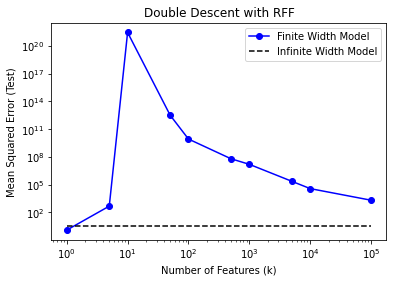

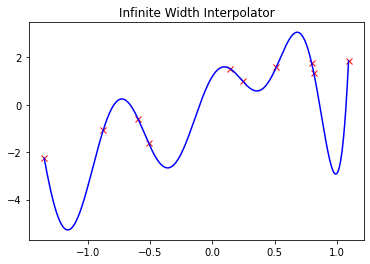

In [3]:
def euclidean_distances(X, Z, squared=True):
    X_norm = np.sum(np.power(X, 2), axis=1, keepdims=True)
    Z_norm = np.sum(np.power(Z, 2), axis=1, keepdims=True).reshape(1, -1)

    distances = X @ Z.T * -2 + X_norm + Z_norm
    
    if not squared:
        distances = np.sqrt(np.clip(distances, a_min=0, a_max=None))
    return distances


def gaussian_kernel(X, X_):
    kernel_mat = euclidean_distances(X, X_)
    kernel_mat = np.clip(kernel_mat, a_min=0, a_max=None) * -1  
    kernel_mat = np.exp(kernel_mat)
    return kernel_mat

# Build kernel matrix for train & test data
K_train = gaussian_kernel(X.T, X.T)
K_test = gaussian_kernel(X.T, X_test.T)
# Solve kernel regression
a_hat = y @ pinv(K_train)

# Get error on train & test data
train_error = mse(a_hat @ K_train, y)
test_error =mse(a_hat @ K_test, y_test)

print("Infinite Width Test Error: ", test_error)
plt.plot(num_features, test_errors, 'bo-', label='Finite Width Model')
plt.plot(num_features, [test_error]*len(num_features), 'k--', 
         label='Infinite Width Model')
plt.legend()
plt.title("Double Descent with RFF")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of Features (k)")
plt.ylabel("Mean Squared Error (Test)")
plt.show()

plt.plot(X[0], y[0], 'rx')
plt.plot(X_test[0], (a_hat @ K_test)[0], 'b-')
plt.title("Infinite Width Interpolator")
plt.show()

We conclude this section with some relevant references: 

1. An introduction to double descent: https://arxiv.org/abs/1812.11118 

2. A theoretical analysis of double descent in linear regression and RFF regression: https://arxiv.org/abs/1903.07571 

3. Random features for large scale kernel machines: https://openreview.net/forum?id=SybDGwbdZB


# Double Descent with the Neural Network Gaussian Process

Thus far, we saw that the RFF model is equivalent to a 1 hidden layer fully connected network where only the last layer is trained.  We can alternatively consider 1 hidden layer fully connected networks with general activation function where only the last layer is trained.  In particular, let us consider a neural network $f(\mathbf{W}; x)$ defined as follows: 
\begin{align*}
    f(\mathbf{W} ; x) = a \frac{\sqrt{c}}{\sqrt{k}} \phi(B x) ~~;
\end{align*}
where $a \in \mathbb{R}^{1 \times k}$, $B \in \mathbb{R}^{k \times d}$, $x \in \mathbb{R}^{d}$, $c \in \mathbb{R}$ is a fixed constant, $\phi$ is an elementwise nonlinearity, and $\mathbf{W}$ is a vectorized version of all entries of $a, B$ (e.g. $\mathbf{W} \in \mathbb{R}^{k + dk}$).  We will also assume that $\phi$ is a real valued function (as is the case in many models in practice).  

For this section, we will consider the case where the entries $B_{ij} \overset{i.i.d}{\sim} \mathcal{N}(0, 1)$ are fixed and only $a$ is trained. In the next notebook, we consider the case where both $a$ and $B$ are updated.  Nevertheless, the analysis of the simpler model in this section will be useful for understanding the more realistic model.  

As for the RFF model, we can of course directly compute the solution for the finite width model.  More interestingly, however, we can (in many cases) directly compute the solution corresponding to the infinite width model above.  

## Infinite Width Analysis for Training Last Layer of Neural Networks

As for the case of RFF, let us analyze the following inner product as $k \to \infty$: 
\begin{align*}
    \frac{c}{k} \langle \phi(Bx), \phi(Bx') \rangle &= \frac{c}{k} \sum_{j=1}^{k} \phi(B_{j, :}x) \phi(B_{j, :}x') ~~;
\end{align*}
where $B_{j, :}$ is the $j^{th}$ row of $B$.  

As before, we can use the law of large numbers to conclude: 
\begin{align*}
    \frac{c}{k} \langle \phi(Bx), \phi(Bx') \rangle \to c \mathbb{E}_{w \sim \mathcal{N}(\mathbf{0}, I_{d \times d})} [\phi(wx) \phi(wx')] ~~;
\end{align*}

Now since $w$ is an isotropic Gaussian, $wx, wx'$ are Gaussians, and we can simplify the expectation above as follows:
\begin{align*}
    c \mathbb{E}_{(u,v) \sim \mathcal{N}(\mathbf{0}, \Lambda)} [\phi(u) \phi(v)]  ~~ ; ~~ \Lambda = \begin{bmatrix} \|x\|_2^2 & x^T x' \\ x^T x' & \|x'\|_2^2 \end{bmatrix}
\end{align*}

When $\|x\|_2 = \|x'\|_2 = 1$ and $c^{-1} = \mathbb{E}_{u \sim \mathcal{N}(0, 1)}[\phi(u)^2]$, we define: 
\begin{align*}
    \check{\phi}(\xi) := c \mathbb{E}_{(u,v) \sim \mathcal{N}(\mathbf{0}, \Lambda)} [\phi(u) \phi(v)] ~~ ; ~~ \Lambda = \begin{bmatrix} 1 & \xi \\ \xi & 1 \end{bmatrix}
\end{align*}

$\check{\phi}$ is referred to as the **dual activation** for $\phi$.  It's properties are studied in https://arxiv.org/pdf/1602.05897.pdf (Section 8).  Dual activations are feasible to compute in closed form for a number of popular nonlinearites including ReLU, LeakyReLU, etc.  In particular, the dual activation for ReLU is given as follows when $c=2$ (it can be computed directly via integration): 

\begin{align*}
    \phi(x) = \max(x, 0) \implies \check{\phi}(\xi) = \frac{1}{\pi} \left(\xi(\pi - \cos^{-1}(\xi)) + \sqrt{1 - \xi^2}\right)
\end{align*}

Such closed forms are useful since they give us a closed form for the kernel corresponding to the infinite width neural network.  For example, for ReLU networks, we have: 
\begin{align*}
    K(x, x') = \check{\phi}(x^T x') = \frac{1}{\pi} \left(\xi(\pi - \cos^{-1}(\xi)) + \sqrt{1 - \xi^2}\right)
\end{align*}


The kernel $K$ is often referred to as the kernel for the Neural Network Gaussian Process (NNGP).  This analysis naturally extends to networks of arbitrary depth where only the last layer is trained.  Given this closed form for the kernel, we can now compare the infinite width random ReLU feature model to the finite width random ReLU feature model (just like we did for the RFF model above). 

1 2.3191529057510505 1.4245138474999042
5 0.24918522996069722 1011.7520367331431
10 0.009825076004312452 311367.2703043201
50 0 3463.3788078308867
100 0 1121.806066681842
500 0 183.8669872166533
1000 0 39.429568364956104
5000 0 4.488825065716377
10000 0 24.548437577782554
100000 0 10.697652358824813


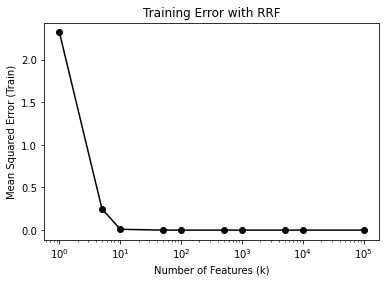

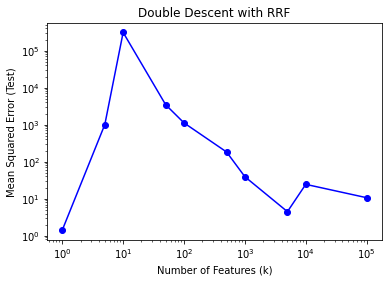

In [4]:
# Finite Width Random ReLU Regression
from numpy.linalg import pinv
SEED = 2134
np.random.seed(SEED)

def mse(preds, labels): 
    return np.mean(np.abs(np.power(preds - labels, 2)))
    

def random_relu_features(X, k=100):
    d, n = X.shape
    V = np.random.randn(k, d)
    b = np.random.randn(k, 1)  ## Model needs a bias term for 1 dimension 
    mat = V @ X + b
    rrf = np.sqrt(2)/np.sqrt(k) * np.where(mat < 0, 0, mat)
    return rrf


# Vary the number of ReLU features used for regression
num_features = [1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 100000]
train_errors = []
test_errors = []

for num_feat in num_features: 
    # Compute Random ReLU Features for train & test data
    phi_X = random_relu_features(X, k=num_feat)
    phi_X_test = random_relu_features(X_test, k=num_feat)

    # Solve linear regression on RRF
    w_hat = y @ pinv(phi_X)
    preds = w_hat @ phi_X_test

    # Compute MSE for test samples
    test_error = mse(preds, y_test)
    test_errors.append(test_error)
    
    train_error = mse(w_hat @ phi_X, y)
    if np.isclose(train_error, 0): 
        train_error = 0
    train_errors.append(train_error)
    print(num_feat, train_error, test_error)

    
plt.plot(num_features, train_errors, 'ko-')
plt.title("Training Error with RRF")
plt.xscale("log")
plt.xlabel("Number of Features (k)")
plt.ylabel("Mean Squared Error (Train)")
plt.show()

plt.plot(num_features, test_errors, 'bo-')
plt.title("Double Descent with RRF")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of Features (k)")
plt.ylabel("Mean Squared Error (Test)")
plt.show()    

Infinite Width Test Error:  0.8432877145009113


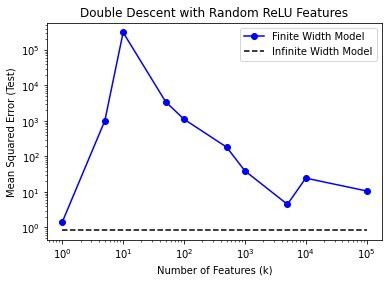

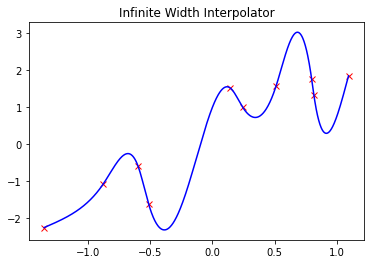

In [5]:
# Infinite Width Random ReLU Feature Regression
def arccos_kernel(pair1, pair2):

    out = pair1 @ pair2.transpose(1, 0) + 1
    N1 = np.sum(np.power(pair1, 2), axis=-1).reshape(-1, 1) + 1
    N2 = np.sum(np.power(pair2, 2), axis=-1).reshape(-1, 1) + 1

    XX = np.sqrt(N1 @ N2.transpose(1, 0))
    out = out / XX

    out = np.clip(out, a_min=-1, a_max=1)

    out = 1/np.pi * (out * (np.pi - np.arccos(out)) \
                           + np.sqrt(1. - np.power(out, 2))) * XX
    return out 

# Build kernel matrix for train & test data
K_train = arccos_kernel(X.T, X.T)
K_test = arccos_kernel(X.T, X_test.T)
# Solve kernel regression
a_hat = y @ pinv(K_train)

# Get error on train & test data
train_error = mse(a_hat @ K_train, y)
test_error =mse(a_hat @ K_test, y_test)

print("Infinite Width Test Error: ", test_error)
plt.plot(num_features, test_errors, 'bo-', label='Finite Width Model')
plt.plot(num_features, [test_error]*len(num_features), 'k--', 
         label='Infinite Width Model')
plt.legend()
plt.title("Double Descent with Random ReLU Features")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of Features (k)")
plt.ylabel("Mean Squared Error (Test)")
plt.show()

plt.plot(X[0], y[0], 'rx')
plt.plot(X_test[0], (a_hat @ K_test)[0], 'b-')
plt.title("Infinite Width Interpolator")
plt.show()

## Training Both Layers

In the next notebook (DoubleDescentTutorialPart2.ipynb), we will analyze the case of training both layers for a 1 hidden layer network.  Under certain conditions, as the number of features goes to infinity, the training dynamics will be explained by the neural tangent kernel. 

## Suggested Exercises

Below is a list of recommended exercise for understanding dual activations and the NNGP.  These results will be generally useful for computing the NTK later.

1. Directly compute $\check{\phi}(\xi)$ above with $c=2$ for $\phi(x) = \max(0, x)$ (e.g. the ReLU function) to verify that for $x, x'$ with $\|x\|_2 = \|x'\|_2 = 1$: 
\begin{align*}
    \check{\phi}(x^T x') = 2 \mathbb{E}_{(u,v) \sim \mathcal{N}(\mathbf{0}, \Lambda)} [\phi(u) \phi(v)] = \frac{1}{\pi} \left(\xi(\pi - \cos^{-1}(\xi)) + \sqrt{1 - \xi^2}\right)
\end{align*}

2. Compute $\check{\psi}(\xi)$ for $\psi(x) = \mathbf{1}_{x > 0}$ (e.g. 1 if $x > 0$ and 0 otherwise).

3. Verify that $\check{\psi} = \frac{d\check{\phi}}{d \xi}$.  

4. Compute the NNGP kernel for a 1 hidden layer ReLU network when: 

    a. The data are not normalized to the unit sphere.  
    b. There is a bias in the first layer (e.g. the network is given by $f(x) = a \frac{\sqrt{2}}{\sqrt{k}} \phi(Bx + C)$ for some $C \in \mathbb{R}^{k}$ with $C_{i} \overset{i.i.d.}{\sim} \mathcal{N}(0, 1)$ ).  

5. Consider a neural network of depth $\ell$ defined as follows: 
\begin{align*}
    f(\mathbf{W} ; x) = W^{(\ell)} \frac{\sqrt{2}}{\sqrt{k_{\ell-1}}} \phi\left( W^{(\ell -1)} \frac{\sqrt{2}}{\sqrt{k_{\ell - 2}}} \phi\left( \ldots W^{(2)} \frac{\sqrt{2}}{\sqrt{k_1}} \phi \left( W^{(1)} x  \right) \ldots \right) \right) ~~; 
\end{align*}
where $x \in \mathbb{R}^{d}$, $W^{(i)} \in \mathbb{R}^{k_{i} \times k_{i-1}}$ with $k_0 = d$ and $k_{\ell} = 1$.  As $k_1, k_2, \ldots k_{\ell-1} \to \infty$, compute the NNGP kernel for $f(\mathbf{W} ; x)$.  Remember that this NNGP kernel corresponds to the case where $W^{(i)}_{a, b} \overset{i.i.d}{\sim} \mathcal{N}(0, 1)$ for $i \in [\ell-1]$ and only $W^{(\ell)}$ is trained.  
